# Setup
## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

In [3]:
# Loading a CSV file into a DataFrame
df = pd.read_csv('../Processed dataset/image_statistics.csv')

# Dimension 
df.shape

(1794, 13)

In [6]:
# Display the first k rows of a DataFrame
df.head(10)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
0,img01.bmp,top_left,part,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789
1,img01.bmp,top_left,void,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178,10.940
2,img01.bmp,top_left,void,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959,10.998
3,img01.bmp,top_left,void,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699,17.444
4,img01.bmp,top_left,void,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419,15.757
5,img01.bmp,top_left,void,5,146,54.770,0.883,0.818,0.912,0.477,20.885,9.814,13.634
6,img01.bmp,top_left,void,6,192,71.835,0.954,-1.440,0.881,0.529,30.397,9.124,15.635
7,img01.bmp,top_left,void,7,322,72.770,0.324,0.429,0.947,0.610,22.009,20.826,20.248
8,img01.bmp,top_left,void,8,342,76.184,0.498,0.893,0.927,0.594,23.752,20.593,20.867
9,img01.bmp,top_left,void,9,292,78.912,0.904,-0.973,0.927,0.438,31.198,13.312,19.282


## Add part_id and num_voids variables

In [10]:
import re

def img_info_to_part_id(imgname, location):
    imgid = int(re.search(r"img(\d+)\.bmp", imgname).group(1))
    if location == "top_left":
        return (imgid - 1) * 4 + 1
    elif location == "bottom_left":
        return (imgid - 1) * 4 + 2
    elif location == "top_right":
        return (imgid - 1) * 4 + 3
    elif location == "bottom_right":
        return (imgid - 1) * 4 + 4
    else:
        raise ValueError("Invalid location: {}".format(location))

# example
print(img_info_to_part_id("img01.bmp", "top_left"))
print(img_info_to_part_id("img01.bmp", "bottom_left"))
print(img_info_to_part_id("img01.bmp", "top_right"))

print(img_info_to_part_id("img02.bmp", "top_left"))
print(img_info_to_part_id("img02.bmp", "bottom_left"))
print(img_info_to_part_id("img02.bmp", "top_right"))

1
2
3
5
6
7


In [14]:
def part_id_to_img_info(part_id):
    pid_copy = part_id - 1
    while pid_copy % 4 != 0:
        pid_copy -= 1
    imgnum = pid_copy // 4 + 1
    imgnum = "{:02d}".format(imgnum)

    if part_id % 4 == 1:
        location = "top_left"
    elif part_id % 4 == 2:
        location = "bottom_left"
    elif part_id % 4 == 3:
        location = "top_right"
    elif part_id % 4 == 0:
        location = "bottom_right"
    else:
        raise ValueError("Invalid part ID: {}".format(part_id))

    return imgnum, location

# example
print(part_id_to_img_info(1))
print(part_id_to_img_info(2))
print(part_id_to_img_info(3))
print(part_id_to_img_info(4))

print(part_id_to_img_info(5))
print(part_id_to_img_info(6))

('01', 'top_left')
('01', 'bottom_left')
('01', 'top_right')
('01', 'bottom_right')
('02', 'top_left')
('02', 'bottom_left')


In [15]:
# Aggiunta di una nuova colonna 'Part_ID' utilizzando la funzione img_info_to_part_id
df['Part_ID'] = df.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)

In [26]:
import random

# Seleziona casualmente un indice
random_index = random.randint(0, len(df) - 1)

# Seleziona la riga corrispondente all'indice casuale
random_row = df.iloc[random_index]

# execute multiple times to check that the column addition worked
# Stampare la riga selezionata casualmente per controllare se l'aggiunta ha funzionato
print("Random selected row:\n", random_row)
print("Correct value from the function: ",img_info_to_part_id(random_row[0],random_row[1]))

Random selected row:
 Image name                         img03.bmp
Position                        bottom_right
Region type                             void
ID                                         2
Area [pixels]                            378
Perimeter [pixels]                    91.012
Eccentricity                           0.894
Orientation [radians]                 -1.533
Solidity                               0.955
Extent                                 0.591
Major Axis Length [pixels]            35.013
Minor Axis Length [pixels]            15.718
Equivalent Diameter [pixels]          21.938
Part_ID                                   12
Name: 495, dtype: object
Correct value from the function:  12


In [28]:
df['Num_voids'] = df.groupby('Part_ID')['ID'].transform('max')
df.head(50)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
0,img01.bmp,top_left,part,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789,1,41
1,img01.bmp,top_left,void,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178,10.940,1,41
2,img01.bmp,top_left,void,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959,10.998,1,41
3,img01.bmp,top_left,void,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699,17.444,1,41
4,img01.bmp,top_left,void,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419,15.757,1,41
5,img01.bmp,top_left,void,5,146,54.770,0.883,0.818,0.912,0.477,20.885,9.814,13.634,1,41
6,img01.bmp,top_left,void,6,192,71.835,0.954,-1.440,0.881,0.529,30.397,9.124,15.635,1,41
7,img01.bmp,top_left,void,7,322,72.770,0.324,0.429,0.947,0.610,22.009,20.826,20.248,1,41
8,img01.bmp,top_left,void,8,342,76.184,0.498,0.893,0.927,0.594,23.752,20.593,20.867,1,41
9,img01.bmp,top_left,void,9,292,78.912,0.904,-0.973,0.927,0.438,31.198,13.312,19.282,1,41


## Classical stuff

In [29]:
# Generate summary statistics for the dataframe 'df'
df.describe()

,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
count,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000
mean,21.978818,1121.736901,157.754262,0.810496,0.104399,0.911231,0.552224,31.534230,18.943464,21.709660,20.481048,43.957637
std,13.040740,5670.111640,599.076427,0.199124,0.993198,0.051993,0.111112,38.249285,39.327878,30.942924,11.555677,2.203124
min,0.000000,1.000000,0.000000,0.000000,-1.571000,0.636000,0.125000,0.000000,0.000000,1.128000,1.000000,40.000000
25%,11.000000,126.250000,50.644750,0.765250,-0.999250,0.894000,0.500000,21.029500,8.052500,12.678500,11.000000,42.000000
50%,22.000000,280.500000,76.770000,0.881000,0.231500,0.927000,0.559000,26.724000,13.548000,18.898000,20.000000,44.000000
75%,33.000000,387.000000,85.386500,0.938000,0.937000,0.943000,0.607000,32.384750,19.502250,22.198000,31.000000,46.000000
max,47.000000,40223.000000,4388.970000,1.000000,1.571000,1.000000,1.000000,280.002000,278.184000,226.304000,40.000000,47.000000


In [30]:
# For now on numeric variables only
dataNum = df.select_dtypes(include=np.number)
dataNum.head(10)

,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
0,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789,1,41
1,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178,10.940,1,41
2,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959,10.998,1,41
3,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699,17.444,1,41
4,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419,15.757,1,41
5,5,146,54.770,0.883,0.818,0.912,0.477,20.885,9.814,13.634,1,41
6,6,192,71.835,0.954,-1.440,0.881,0.529,30.397,9.124,15.635,1,41
7,7,322,72.770,0.324,0.429,0.947,0.610,22.009,20.826,20.248,1,41
8,8,342,76.184,0.498,0.893,0.927,0.594,23.752,20.593,20.867,1,41
9,9,292,78.912,0.904,-0.973,0.927,0.438,31.198,13.312,19.282,1,41


## Df split into parts and voids

In [35]:
# Creazione di df_parts selezionando le righe con "Region type" pari a "part"
df_parts = df[df['Region type'] == 'part']

# Creazione di df_voids selezionando le righe con "Region type" pari a "void"
df_voids = df[df['Region type'] == 'void']

In [39]:
df_parts.head(10)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
0,img01.bmp,top_left,part,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789,1,41
42,img01.bmp,bottom_left,part,0,38974,4087.348,0.148,-1.234,0.767,0.721,278.216,275.169,222.763,2,42
85,img01.bmp,top_right,part,0,39176,3988.051,0.163,1.528,0.780,0.712,275.773,272.072,223.339,3,46
132,img01.bmp,bottom_right,part,0,38904,4011.739,0.161,-1.186,0.772,0.670,276.860,273.250,222.563,4,47
180,img02.bmp,top_left,part,0,38376,4133.306,0.119,-0.789,0.755,0.707,278.803,276.832,221.047,5,42
223,img02.bmp,bottom_left,part,0,38086,4233.674,0.104,-0.863,0.750,0.729,279.073,277.567,220.210,6,42
266,img02.bmp,top_right,part,0,37905,4290.058,0.052,-0.869,0.752,0.723,277.310,276.929,219.686,7,47
314,img02.bmp,bottom_right,part,0,38740,4084.335,0.128,-0.828,0.764,0.720,277.947,275.666,222.093,8,44
359,img03.bmp,top_left,part,0,39202,4034.821,0.125,-1.325,0.774,0.722,276.453,274.286,223.413,9,43
403,img03.bmp,bottom_left,part,0,39079,4049.892,0.135,-1.164,0.771,0.714,277.074,274.527,223.063,10,43


In [41]:
df_voids.head(50)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
1,img01.bmp,top_left,void,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178,10.940,1,41
2,img01.bmp,top_left,void,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959,10.998,1,41
3,img01.bmp,top_left,void,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699,17.444,1,41
4,img01.bmp,top_left,void,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419,15.757,1,41
5,img01.bmp,top_left,void,5,146,54.770,0.883,0.818,0.912,0.477,20.885,9.814,13.634,1,41
6,img01.bmp,top_left,void,6,192,71.835,0.954,-1.440,0.881,0.529,30.397,9.124,15.635,1,41
7,img01.bmp,top_left,void,7,322,72.770,0.324,0.429,0.947,0.610,22.009,20.826,20.248,1,41
8,img01.bmp,top_left,void,8,342,76.184,0.498,0.893,0.927,0.594,23.752,20.593,20.867,1,41
9,img01.bmp,top_left,void,9,292,78.912,0.904,-0.973,0.927,0.438,31.198,13.312,19.282,1,41
10,img01.bmp,top_left,void,10,306,75.527,0.731,0.131,0.916,0.567,25.444,17.365,19.739,1,41


# Visual Exploration

## Images reorientation and cut

In [51]:
#  todo
import os
cartella_immagini = '../Processed dataset/'

def genera_percorso_immagine(part_id, cartella_immagini,option="segmented"):
    imgnum, location = part_id_to_img_info(part_id)
    nome_immagine = f"img{imgnum}.bmp_{location}_{option}.png"
    return os.path.join(cartella_immagini, nome_immagine)

# Utilizzo della funzione
print(genera_percorso_immagine(1, cartella_immagini))
print(genera_percorso_immagine(2, cartella_immagini))
print(genera_percorso_immagine(5, cartella_immagini))
print(genera_percorso_immagine(6, cartella_immagini))

../Processed dataset/img01.bmp_top_left_segmented.png
../Processed dataset/img01.bmp_bottom_left_segmented.png
../Processed dataset/img02.bmp_top_left_segmented.png
../Processed dataset/img02.bmp_bottom_left_segmented.png


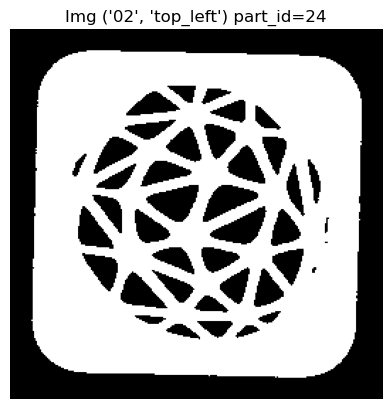

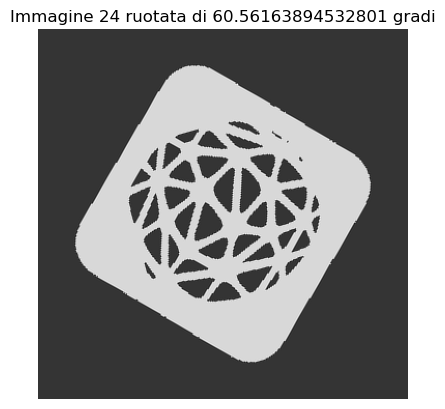

In [82]:
from scipy import ndimage
import math
part_id = random.randint(1, 40)

img = plt.imread(genera_percorso_immagine(part_id, cartella_immagini))
plt.imshow(img, cmap='gray')
plt.title(f"Img {part_id_to_img_info(5)} part_id={part_id}")
plt.axis('off')
plt.show()
# it doesnt seem to work this rotation
angolo = math.degrees(df.loc[part_id, 'Orientation [radians]'])
img_ruotata = ndimage.rotate(img, angolo)
plt.imshow(img_ruotata, cmap='gray')
plt.title(f'Immagine {part_id} ruotata di {angolo} gradi')
plt.axis('off')  # Nascondi gli assi
plt.show()

In [188]:
def crop_rect(img, rect, verbose=0):
    # get the parameter of the small rectangle
    center, size, angle = rect[0], rect[1], rect[2]
    
    if angle > 45:
        angle = angle - 90
    
    if verbose == 1:
        print(f"Angle inside function is {angle}")
    
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    height, width = img.shape[0], img.shape[1]

    # calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1)
    # rotate the original image
    img_rot = cv2.warpAffine(img, M, (width, height))

    # now rotated rectangle becomes vertical, and we crop it
    img_crop = cv2.getRectSubPix(img_rot, size, center)

    return img_crop, img_rot


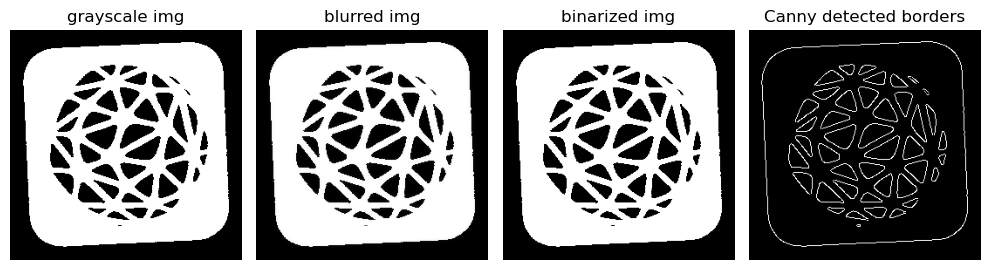

Angle here is 87.33700561523438
Angle inside function is -2.662994384765625
Angle in df was 0.195 radians, ie 11.172677005051053 degrees


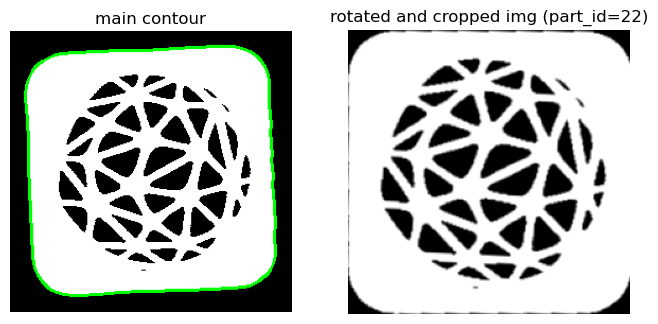

In [190]:
import cv2
import skimage
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
import pylab
import pandas as pd

# part_id = 22
part_id = random.randint(1,40)
img = cv2.imread(genera_percorso_immagine(part_id, cartella_immagini),)

# Converti l'immagine in scala di grigi
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(gray, cmap='gray')
plt.title('grayscale img')
plt.axis('off')

# Applica il filtro bilaterale per ridurre il rumore
blurred_img = cv2.bilateralFilter(gray, 10, 100, 100)
plt.subplot(1, 4, 2)
plt.imshow(blurred_img, cmap='gray')
plt.title('blurred img')
plt.axis('off')

# Applica la binarizzazione Otsu
(T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# (T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.subplot(1, 4, 3)
plt.imshow(threshInv, cmap='gray')
plt.title('binarized img')
plt.axis('off')

# Apply the Canny filter to detect edges
edged = cv2.Canny(threshInv, 30, 200)
plt.subplot(1, 4, 4)
plt.imshow(edged, cmap='gray')
plt.title('Canny detected borders')
plt.axis('off')
plt.tight_layout()
plt.show()

# Find the contours
contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

# Select only the four biggest contour (it takes 2 per image for this reason there is [:8]
largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

img_with_contours = img.copy()
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
cv2.drawContours(img_with_contours, largest_contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
plt.title('main contour')
plt.axis('off')

# crop the pictures following the four biggest contours
for i, contours in enumerate (largest_contours):
	# if i % 2 == 0:
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		print(f"Angle here is {rect[2]}")
		cropped_image, rot_image = crop_rect(img, rect, verbose=1)
		print(f"Angle in df was {df.loc[part_id, 'Orientation [radians]']} radians, ie {math.degrees(df.loc[part_id, 'Orientation [radians]'])} degrees")
		# cropped_images.append(cropped_image)                
		# cropped_filename = os.path.splitext(filename)[0] + "_crp{}.jpg".format(i+1)

		plt.subplot(1, 2, 2)
		plt.imshow(cropped_image)
		plt.title(f"rotated and cropped img (part_id={part_id})")
		plt.axis('off')
		plt.show()

## Classical plots

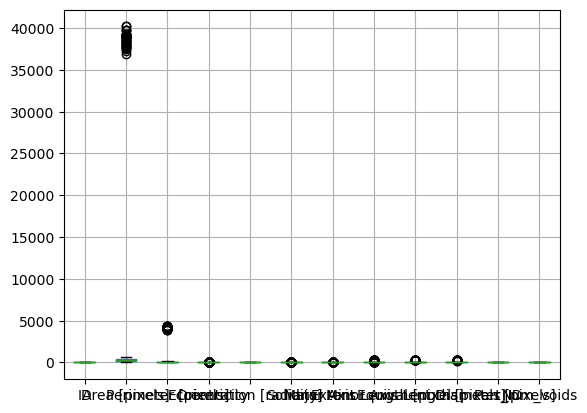

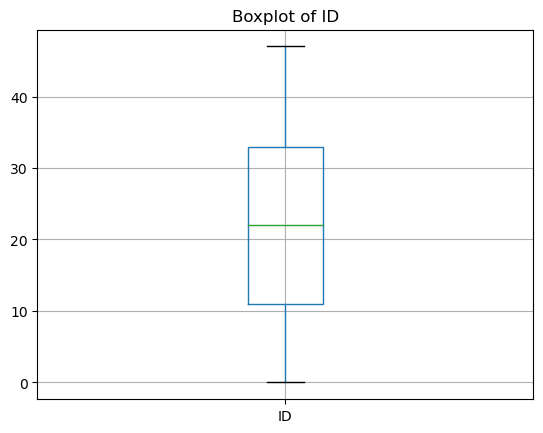

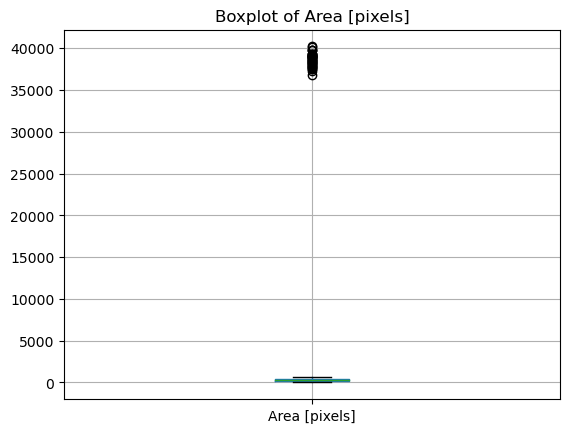

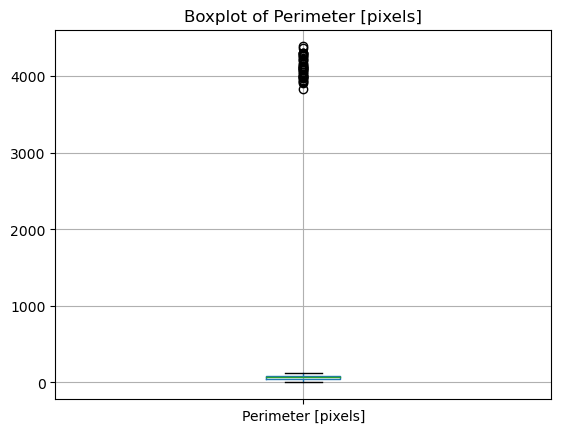

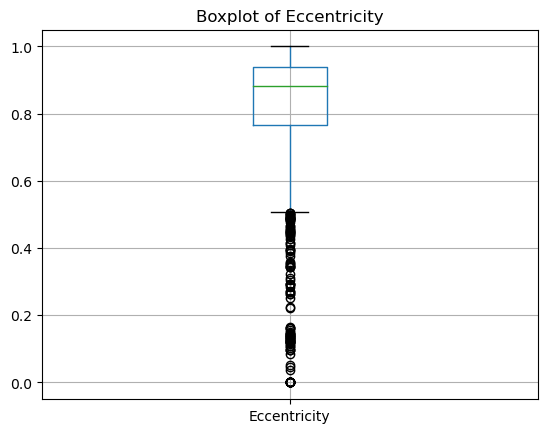

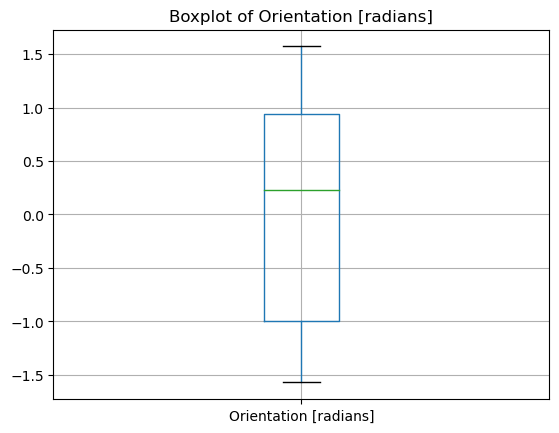

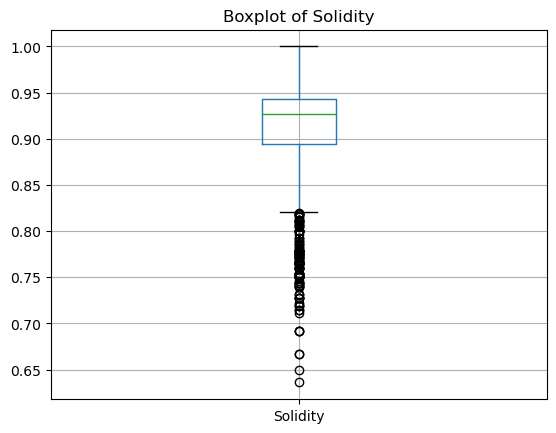

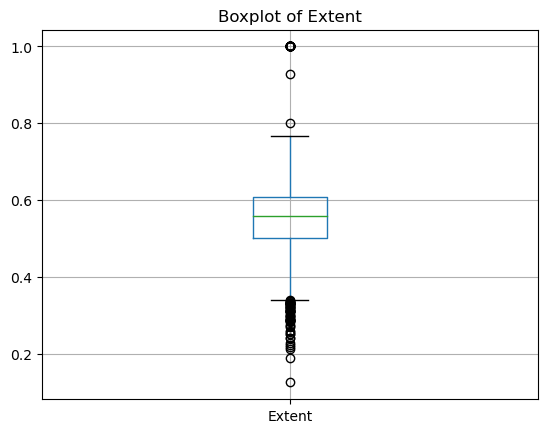

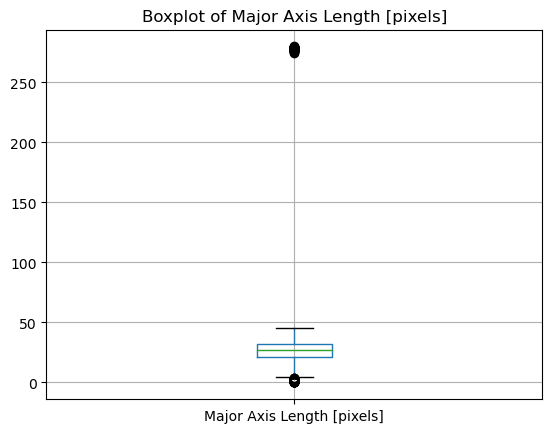

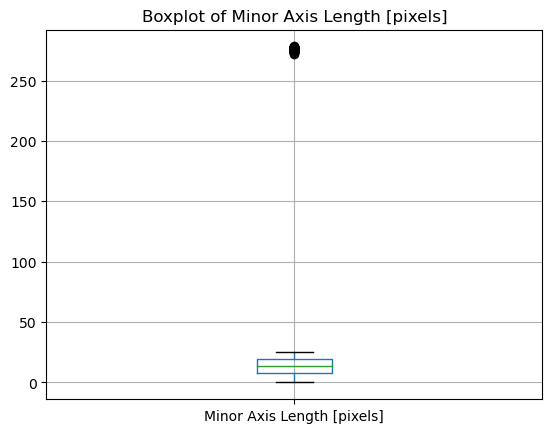

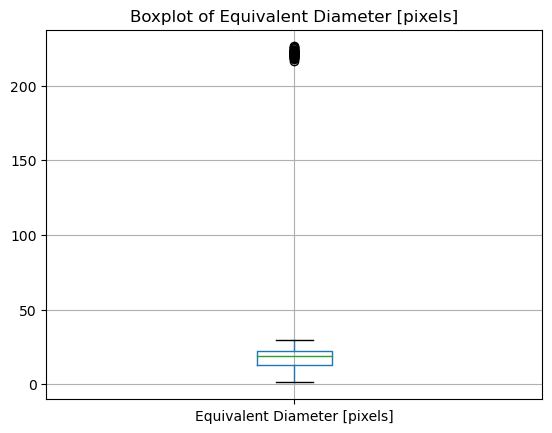

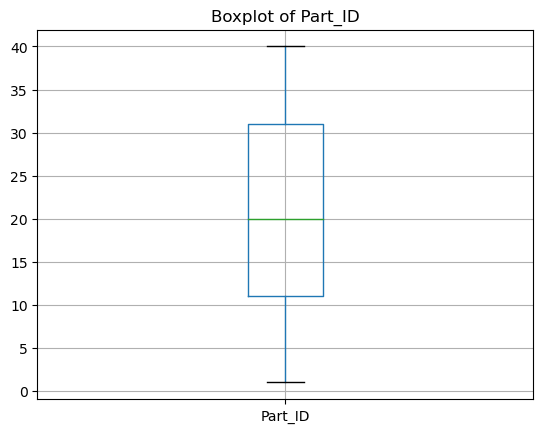

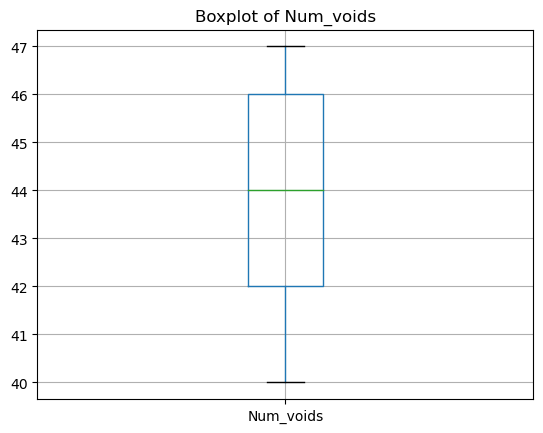

In [31]:
# Boxplot
df.boxplot(dataNum.columns.tolist())
plt.show() 

# Assuming dataNum is your DataFrame containing numerical data
for col in dataNum.columns.tolist():
    dataNum.boxplot(col)
    plt.title(f'Boxplot of {col}')
    plt.show()

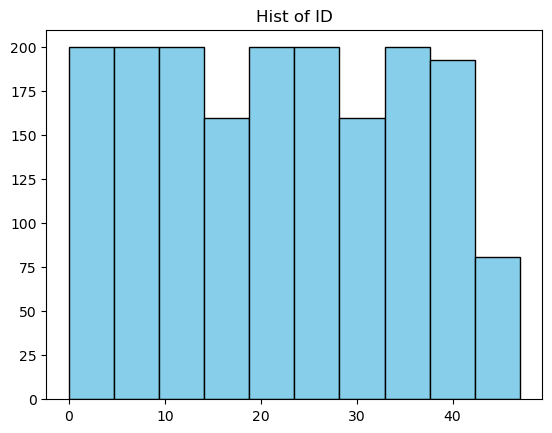

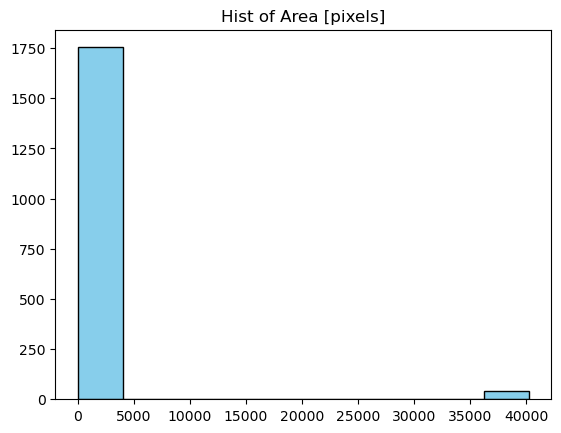

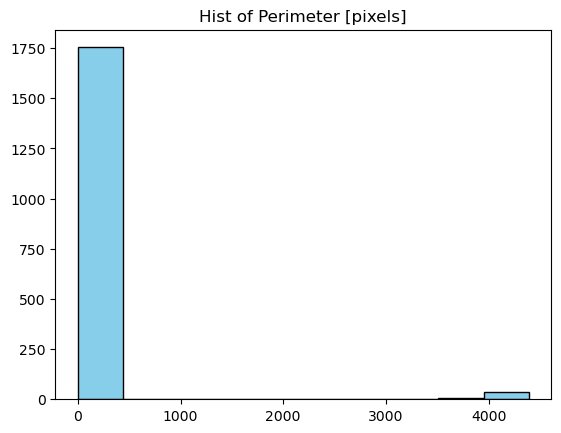

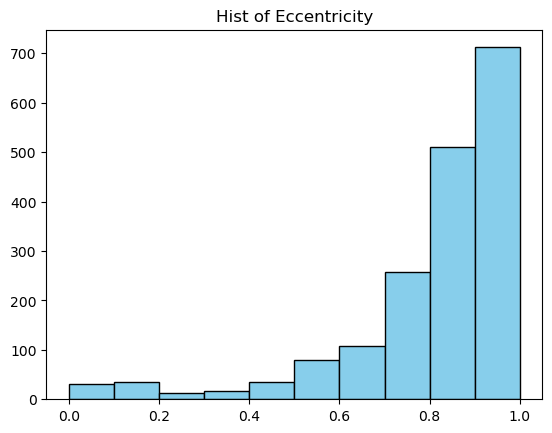

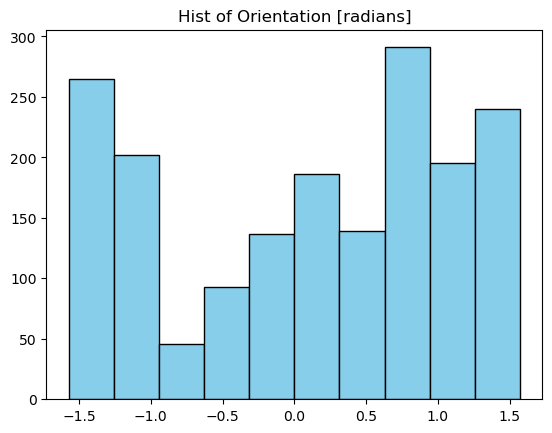

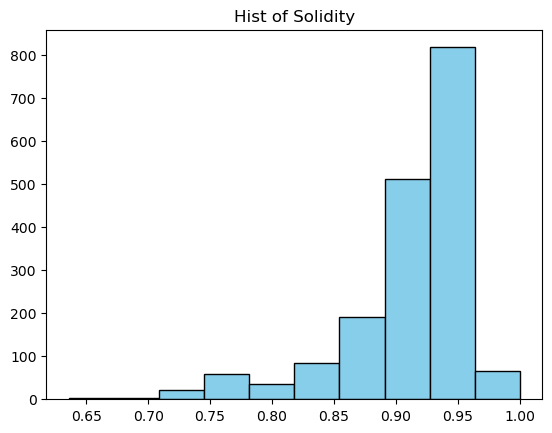

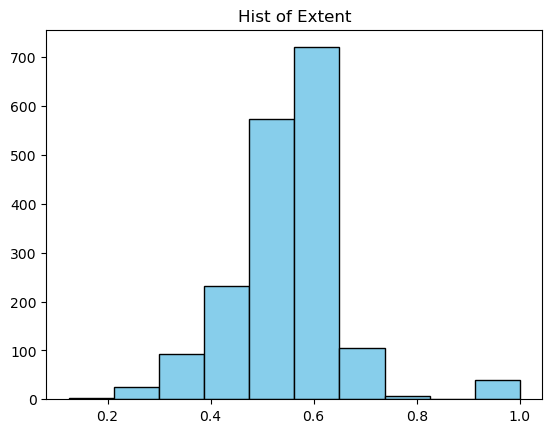

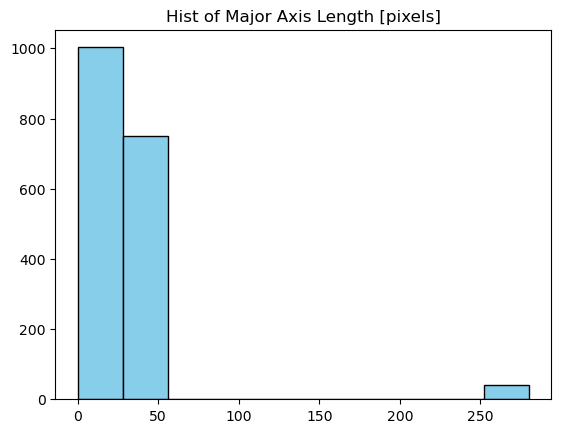

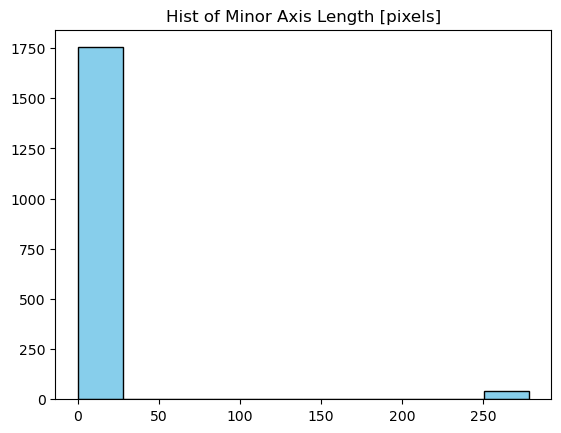

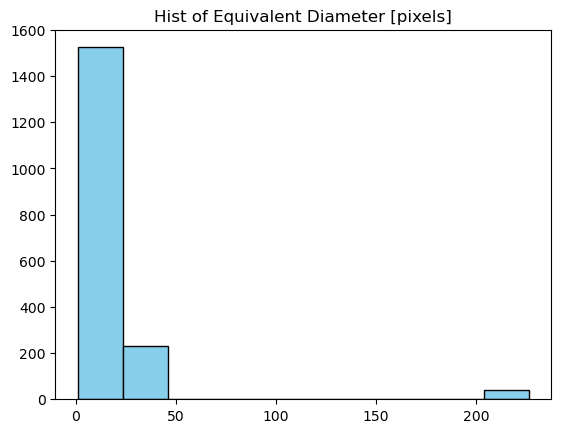

In [71]:
for col in dataNum.columns.tolist():
  plt.hist(dataNum[col], bins=10, color='skyblue', edgecolor='black')
  plt.title(f'Hist of {col}')
  plt.show()


Looking only at the singular images... it seems that the distribution are quite the same

In [85]:
img01_df = df.loc[df['Image name'] == 'img01.bmp', df.columns[3:12]]
img01_df

,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels]
0,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023
1,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178
2,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959
3,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699
4,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419
...,...,...,...,...,...,...,...,...,...
175,43,1,0.000,0.000,0.785,1.000,1.000,0.000,0.000
176,44,137,55.698,0.940,1.245,0.907,0.476,23.624,8.073
177,45,1,0.000,0.000,0.785,1.000,1.000,0.000,0.000
178,46,74,37.971,0.933,-1.287,0.881,0.544,16.737,6.026


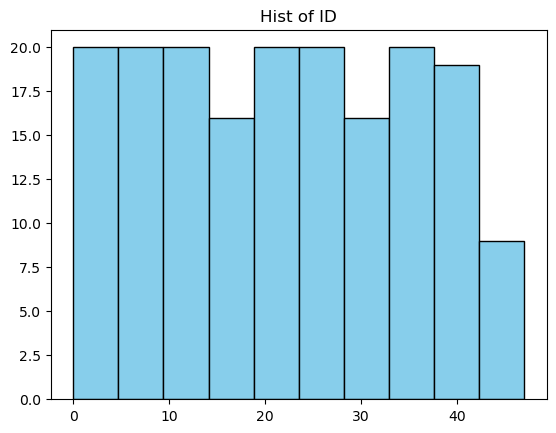

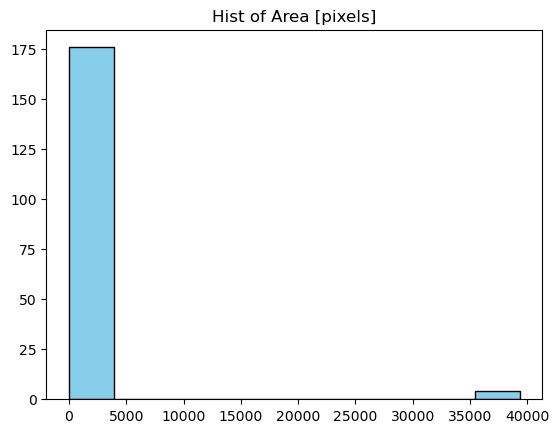

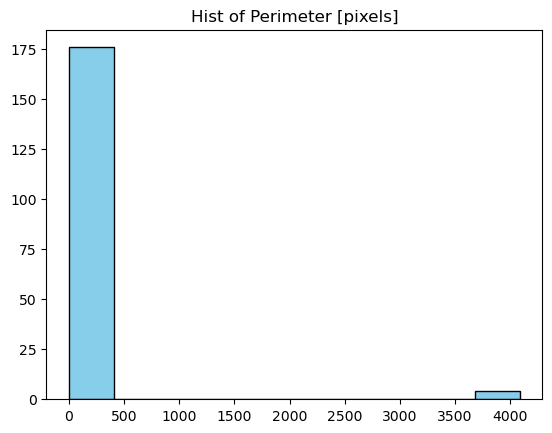

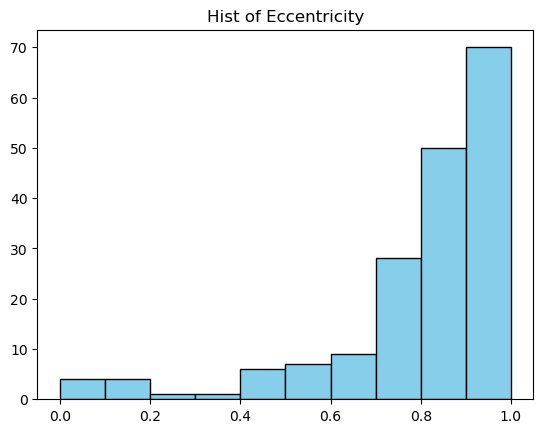

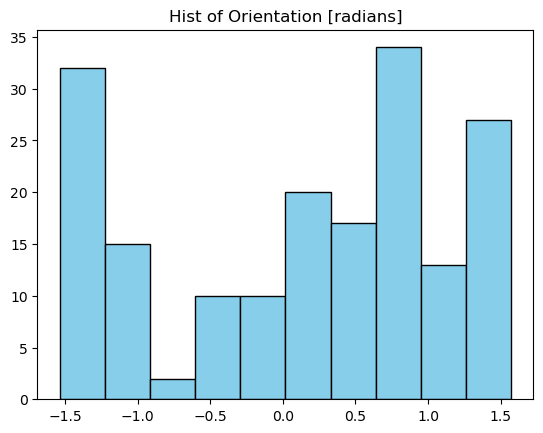

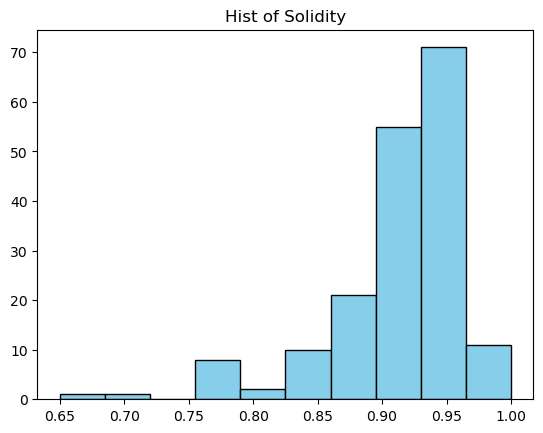

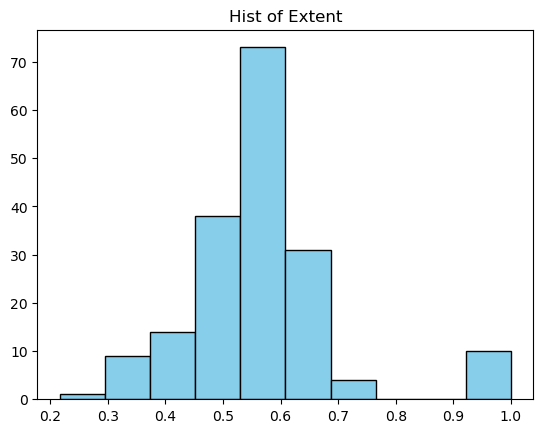

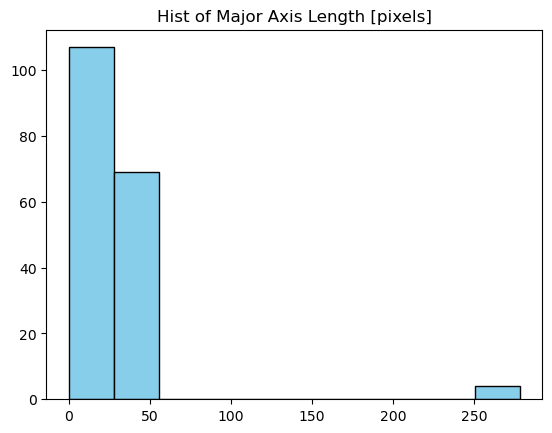

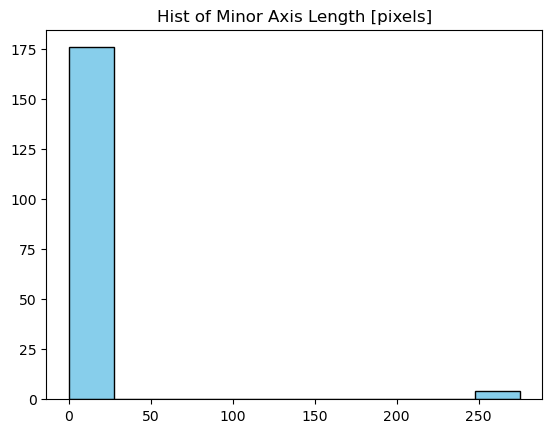

In [83]:
# Seleziona solo le righe con 'Image name' uguale a 'img01.bmp'
img01_df = df.loc[df['Image name'] == 'img01.bmp', df.columns[3:12]]

# Itera sulle colonne di questo sotto-dataframe
for col in img01_df.columns.tolist():
    plt.hist(img01_df[col], bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Hist of {col}')
    plt.show()


Some notes:  
- which is the scope?  
- can we create new variables?  
-  adding image analysis  
- the eccentricity --> log(-eccentricity) ( for normality)  
- remove outliers/ interpret them


## Normality assumption

In [21]:
for col in dataNum.columns.tolist():
  # Shapiro-Wilk test
  _, p_value_SW = stats.shapiro(dataNum[col])
  print('p-value of the Shapiro-Wilk ', col, ' test: %.3f' % p_value_SW)

p-value of the Shapiro-Wilk  ID  test: 0.000
p-value of the Shapiro-Wilk  Area [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Perimeter [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Eccentricity  test: 0.000
p-value of the Shapiro-Wilk  Orientation [radians]  test: 0.000
p-value of the Shapiro-Wilk  Solidity  test: 0.000
p-value of the Shapiro-Wilk  Extent  test: 0.000
p-value of the Shapiro-Wilk  Major Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Minor Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Equivalent Diameter [pixels]  test: 0.000


In [ ]:
# QQ-plot
for col in dataNum.columns.tolist():
  stats.probplot(dataNum[col], dist='norm', plot=plt)
  plt.show()

In [27]:
# Anderson-Darling test ???? SOME PROBLEMS

def ADpvalue(data):
    """
    This function computes the p-value of the Anderson-Darling test.
    
    Input:
        data: data to be tested
    Output:
        p_value_AD: p-value of the Anderson-Darling test
    """
    anderson = stats.anderson(data, dist='norm')
    # compute the p-value of the Anderson-Darling test
    if anderson.statistic >= 0.6:
        p_value_AD = np.exp(1.2937 - 5.709*anderson.statistic + 0.0186*(anderson.statistic**2))
    elif anderson.statistic >= 0.34:
        p_value_AD = np.exp(0.9177 - 4.279*anderson.statistic - 1.38*(anderson.statistic**2))
    elif anderson.statistic >= 0.2:
        p_value_AD = 1 - np.exp(-8.318 + 42.796*anderson.statistic - 59.938*(anderson.statistic**2))
    else:
        p_value_AD = 1 - np.exp(-13.436 + 101.14*anderson.statistic - 223.73*(anderson.statistic**2))

    return p_value_AD

# Example usage with a DataFrame 'dataNum'
# Assuming 'dataNum' is your DataFrame containing numerical data
# Assuming each column in 'dataNum' represents a variable you want to test

for col in dataNum.columns.tolist():  
    p_value_AD = ADpvalue(dataNum[col])
    print(f'p-value of the Anderson-Darling test for {col}: {p_value_AD:.3f}')


p-value of the Anderson-Darling test for ID: 0.000
p-value of the Anderson-Darling test for Area [pixels]: inf
p-value of the Anderson-Darling test for Perimeter [pixels]: inf
p-value of the Anderson-Darling test for Eccentricity: 0.000
p-value of the Anderson-Darling test for Orientation [radians]: 0.000
p-value of the Anderson-Darling test for Solidity: 0.000
p-value of the Anderson-Darling test for Extent: 0.000
p-value of the Anderson-Darling test for Major Axis Length [pixels]: 1511030393770227162003779399905844333357419357264268208936458972611295710864454567262998905429485439856992987283169820189994024308959741793337201646307926041823825486650119331757704464815929662145550627110912.000
p-value of the Anderson-Darling test for Minor Axis Length [pixels]: inf
p-value of the Anderson-Darling test for Equivalent Diameter [pixels]: 19315448332851835944334324422462959672560793981042361528673147246919530470579697039170133220422593838138142737771726343084849060416283304997276745743537487

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [48]:
min(dataNum['Orientation [radians]'])

-1.571

Since for the scipy.special.boxcox transformation all variables must be positive, I apply a linear transformation to all the dataset --> dataset.pos = datset + pi/2+0.001.  
Rotate pi/2 Cartesian axis ( see slides REGION PROPERTIES - ORIENTATION)

Note that i chose to use this thpe of trasformation becuause the majority of the problem are related to the orientation column, in this way we obtain all positive values.

In [59]:
import math

dataNumTrasf = pd.DataFrame()  # Initialize an empty DataFrame to store transformed data

# Assuming dataNum is your DataFrame containing numerical data
dataNumTrasf = dataNum.iloc[:, 1:] + math.pi/2 + 0.001 # remove ID column

In [58]:
dataNumTrasf.head(100)

,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
0,39335.571796,3981.463796,1.716796,0.172796,2.346796,2.229796,278.512796,275.594796,225.360796
1,95.571796,39.127796,2.344796,3.016796,2.520796,2.267796,16.034796,10.749796,12.511796
2,96.571796,47.713796,2.506796,0.105796,2.443796,2.136796,21.218796,8.530796,12.569796
3,240.571796,79.098796,2.513796,0.139796,2.480796,2.140796,33.555796,12.270796,19.015796
4,196.571796,62.991796,2.456796,3.116796,2.478796,2.148796,26.106796,12.990796,17.328796
...,...,...,...,...,...,...,...,...,...
95,242.571796,68.648796,2.381796,1.856796,2.484796,2.138796,25.939796,15.863796,19.088796
96,384.571796,82.583796,2.277796,2.347796,2.507796,2.160796,29.174796,21.125796,23.654796
97,356.571796,91.755796,2.483796,0.184796,2.470796,2.104796,37.079796,16.145796,22.831796
98,43.571796,30.920796,2.549796,1.044796,2.335796,1.894796,17.980796,4.993796,8.884796


In [60]:

# Box-Cox transformation

data_norm = pd.DataFrame() 

for col in dataNumTrasf.columns.tolist():
    data_norm[col], lmbda = stats.boxcox(dataNumTrasf[col])
    print(f'Lambda for {col} = {lmbda:.3f}')


Lambda for Area [pixels] = -0.012
Lambda for Perimeter [pixels] = -0.019
Lambda for Eccentricity = 10.371
Lambda for Orientation [radians] = 0.774
Lambda for Solidity = 24.228
Lambda for Extent = -1.098
Lambda for Major Axis Length [pixels] = 0.059
Lambda for Minor Axis Length [pixels] = -0.087
Lambda for Equivalent Diameter [pixels] = -0.095


In [61]:
data_norm.head(10)

,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels]
0,9.944978,7.666808,26.110187,-0.960220,3.903302e+07,0.533177,6.684819,4.446268,4.239288
1,4.439151,3.541439,664.375719,1.744540,2.208003e+08,0.540118,3.016493,2.145993,2.247459
2,4.449013,3.726065,1328.443578,-1.065175,1.041326e+08,0.515095,3.349568,1.955975,2.251100
3,5.309089,4.193330,1367.424798,-1.010473,1.498645e+08,0.515907,3.906614,2.253050,2.570642
4,5.119550,3.983407,1077.934313,1.822140,1.469646e+08,0.517520,3.599654,2.298799,2.500018
5,4.849733,3.880213,1068.867624,1.243592,1.543175e+08,0.496396,3.417669,2.192644,2.399607
6,5.105100,4.124578,1436.660822,-1.023044,1.138323e+08,0.507644,3.847009,2.141894,2.494621
7,5.586402,4.136237,73.204877,0.917889,2.165949e+08,0.524046,3.476507,2.724626,2.674075
8,5.642396,4.177573,182.130339,1.304954,1.785531e+08,0.520908,3.562726,2.716640,2.694946
9,5.495477,4.209296,1167.598472,-0.423315,1.785531e+08,0.487559,3.877433,2.407034,2.640173


In [62]:
for col in data_norm.columns.tolist():
  # Shapiro-Wilk test
  _, p_value_SW = stats.shapiro(data_norm[col])
  print('p-value of the Shapiro-Wilk ', col, ' test: %.3f' % p_value_SW)

p-value of the Shapiro-Wilk  Area [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Perimeter [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Eccentricity  test: 0.000
p-value of the Shapiro-Wilk  Orientation [radians]  test: 0.000
p-value of the Shapiro-Wilk  Solidity  test: 0.000
p-value of the Shapiro-Wilk  Extent  test: 0.000
p-value of the Shapiro-Wilk  Major Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Minor Axis Length [pixels]  test: 0.000
p-value of the Shapiro-Wilk  Equivalent Diameter [pixels]  test: 0.000


The box cox trasformation does not solve the pb of guassian distrution -> we can try more values for lambda / outlier analysis

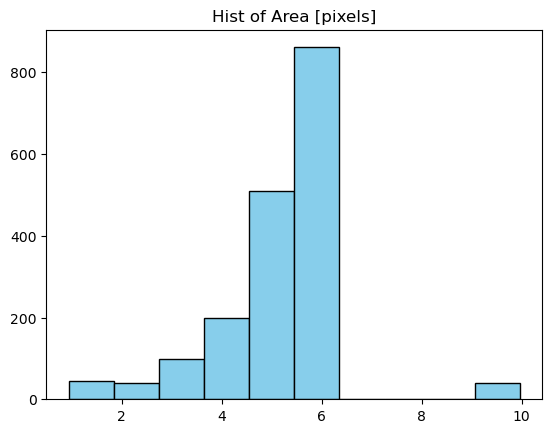

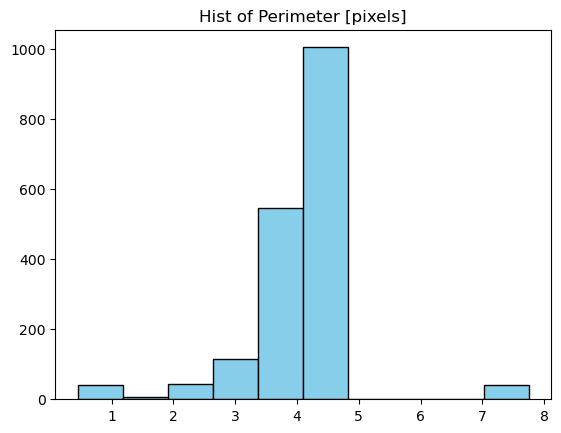

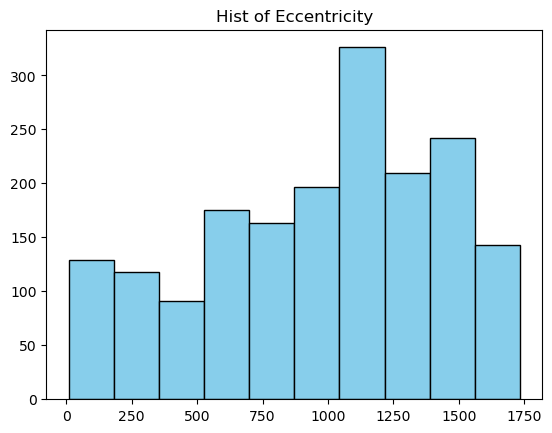

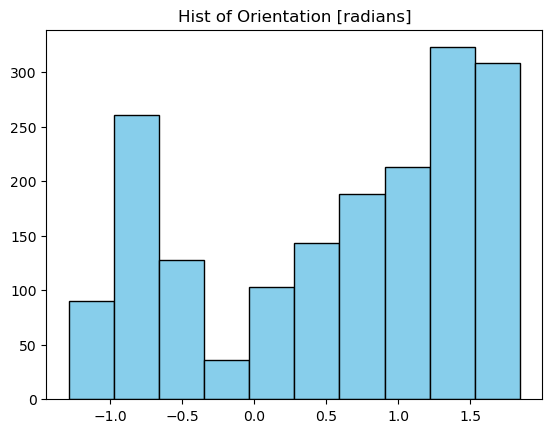

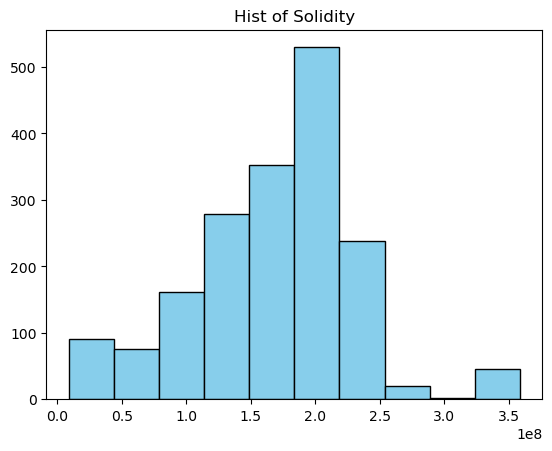

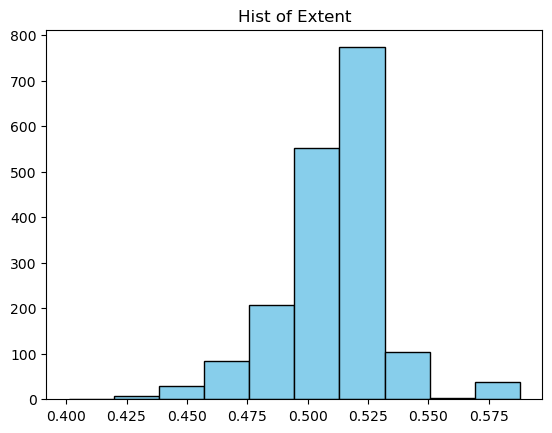

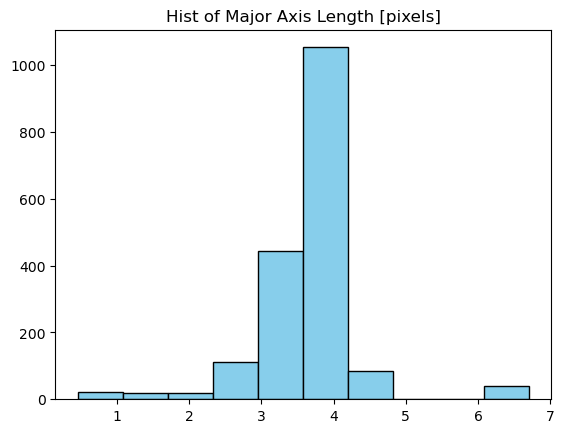

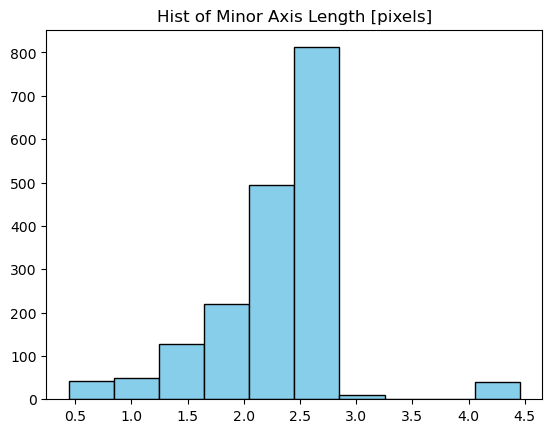

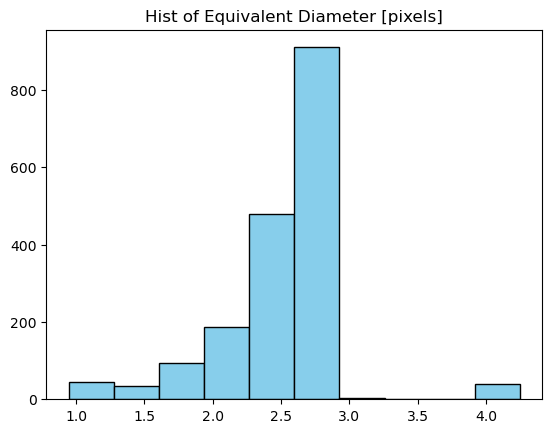

In [66]:
for col in data_norm.columns.tolist():
  # Shapiro-Wilk test
  plt.hist(data_norm[col], bins=10, color='skyblue', edgecolor='black')
  plt.title(f'Hist of {col}')
  plt.show()


